## Albumentations

In [203]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
from tqdm import tqdm
from time import sleep

## Transform definition

In [195]:
transform = A.Compose([
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2),
        A.RandomGamma(gamma_limit=(80, 120)),
        A.ShiftScaleRotate(scale_limit=0.3, rotate_limit=30),
        A.OneOf([A.NoOp(), A.MultiplicativeNoise(), A.GaussNoise(), A.ISONoise()]),
        A.OneOf(
            [A.NoOp(p=0.8),
             A.HueSaturationValue(hue_shift_limit=30, sat_shift_limit=30),
             A.RGBShift(r_shift_limit=50, g_shift_limit=50, b_shift_limit=50),
            ],
            p=0.5,
        ),
        A.OneOf([A.ElasticTransform(), A.GridDistortion(), A.NoOp()]),
        A.HorizontalFlip(p=0.5),
        A.Blur(p=0.1),
    ])

## Transform testing

In [82]:
test_path = '/opt/ml/input/data/train_aug/images/000001_female_Asian_45/normal.jpg'

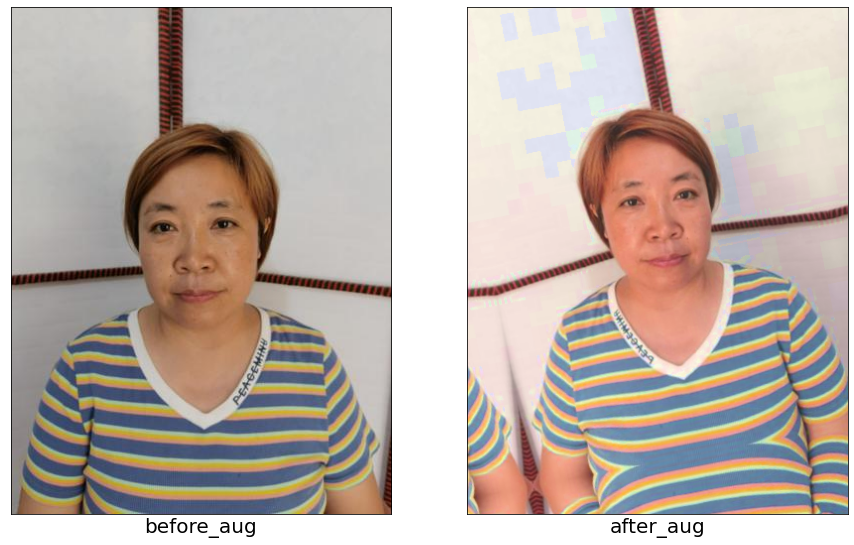

In [105]:
fig = plt.figure(figsize=(15, 10))
test = cv2.imread(test_path)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(cv2.cvtColor(test, cv2.COLOR_BGR2RGB))
ax.set_xlabel('before_aug', fontsize=20)
ax.set_xticks([])
ax.set_yticks([])

augmentations = transform(image=test)
test_aug = augmentations['image']

ax2 = fig.add_subplot(1, 2, 2)
ax2.imshow(cv2.cvtColor(test_aug, cv2.COLOR_BGR2RGB))
ax2.set_xlabel('after_aug', fontsize=20)
ax2.set_xticks([])
ax2.set_yticks([])

plt.show()

## Transform applying

In [106]:
train_path = '/opt/ml/input/data/train_aug'

In [212]:
train_csv = pd.read_csv(os.path.join(train_path, 'train.csv'))
train_csv

,id,gender,race,age,path
0,000001,female,Asian,45,000001_female_Asian_45
1,000002,female,Asian,52,000002_female_Asian_52
2,000004,male,Asian,54,000004_male_Asian_54
3,000005,female,Asian,58,000005_female_Asian_58
4,000006,female,Asian,59,000006_female_Asian_59
...,...,...,...,...,...
2695,006954,male,Asian,19,006954_male_Asian_19
2696,006955,male,Asian,19,006955_male_Asian_19
2697,006956,male,Asian,19,006956_male_Asian_19
2698,006957,male,Asian,20,006957_male_Asian_20


In [213]:
def ModifyCsv(ImageInfo):
    global train_csv
    new_data = {
        'id': ImageInfo[0], 
        'gender': ImageInfo[1], 
        'race': ImageInfo[2], 
        'age': ImageInfo[3], 
        'path': ImageInfo[4]
    }
    train_csv = train_csv.append(new_data, ignore_index=True)

def ImageAugmentation(path):
    new_idx = 6960    # 기존 6960번 images 이후로 저장
    folder_n = 0
    file_n = 0
    
    # train image의 모든 profile directory
    for folder in tqdm(glob.glob(f'{path}/{00}*')):
        age = folder.split('images/')[1].split('_')[3][:2]
        
        # [0~30:30~55:55~90] 구간으로 나눴을 때 비율 약 2:1:1 => 30살 이상 모두 2배로 증강
        if int(age) >= 30:
            folder_n += 1
            gender = folder.split('images/')[1].split('_')[1]
            race = folder.split('images/')[1].split('_')[2]
            
            img_root = '_'.join([str(new_idx).zfill(6),gender,race,age])
            # images(새 폴더) 저장과 함께 기존 csv에 label 추가
            ModifyCsv([str(new_idx).zfill(6), gender, 'Asian', age, img_root])
            new_idx += 1
            img_root_path = os.path.join(train_path, 'images', img_root)
            os.mkdir(img_root_path)
            
            # Profile 폴더 내 모든 이미지 증강
            for imagefile in glob.glob(f'{folder}/*.jpg'):
                file_n += 1
                img=cv2.imread(imagefile)
                
                # albumentation의 augmentation 적용
                augmentations = transform(image=img)
                img_aug = augmentations['image']
                file_root_path = os.path.join(img_root_path, imagefile.split('/')[8])
                
                # augmentation 적용된 이미지 저장
                cv2.imwrite(file_root_path, img_aug)
    
    print("Changed Folder:",folder_n*2,'개, Changed File:',file_n*2)

In [214]:
ImageAugmentation(os.path.join(train_path, 'images'))

100%|██████████| 2700/2700 [09:49<00:00,  4.58it/s]

Changed Folder: 2838 개, Changed File: 19866


In [215]:
train_csv.to_csv(os.path.join(train_path, 'train_augmented.csv'), index=False)

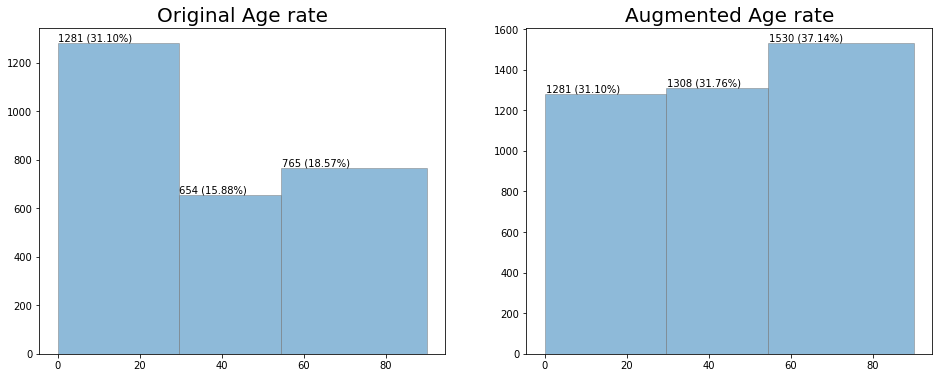

In [222]:
origin_csv = pd.read_csv(os.path.join(train_path, 'train.csv'))
augmented_csv = pd.read_csv(os.path.join(train_path, 'train_augmented.csv'))


fig = plt.figure(figsize=(16,6))

ax1 = fig.add_subplot(1, 2, 1)
ax1.hist(origin_csv['age'], alpha=0.5, edgecolor='grey', bins=[0, 29.5, 54.5, 90])
ax1.set_title("Original Age rate", fontsize=20)
for p in ax1.patches:
        ax1.annotate('{:.0f} ({:.2f}%)'.format(p.get_height(), (p.get_height() / len(train_csv)) * 100), 
                    (p.get_x()+0.1, p.get_height()+10), fontsize=10)
        
ax2 = fig.add_subplot(1,2,2)
ax2.hist(augmented_csv['age'], alpha=0.5, edgecolor='grey', bins=[0, 29.5, 54.5, 90])
ax2.set_title("Augmented Age rate", fontsize=20)
for p in ax2.patches:
        ax2.annotate('{:.0f} ({:.2f}%)'.format(p.get_height(), (p.get_height() / len(train_csv)) * 100), 
                    (p.get_x()+0.25, p.get_height()+10), fontsize=10)
        
plt.show()